# Deep Q-Network

In [1]:
import random
import sys
from time import time
from collections import deque, defaultdict, namedtuple
import numpy as np
import pandas as pd
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('cuda:0')

## Model 1

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(NeuralNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 64)
        self.fc4 = nn.Linear(64, action_size)  
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x 

## Model 2

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(NeuralNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, action_size)   
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x 

## Model 3

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(NeuralNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, action_size)     
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x 

## ε-greedy policy test

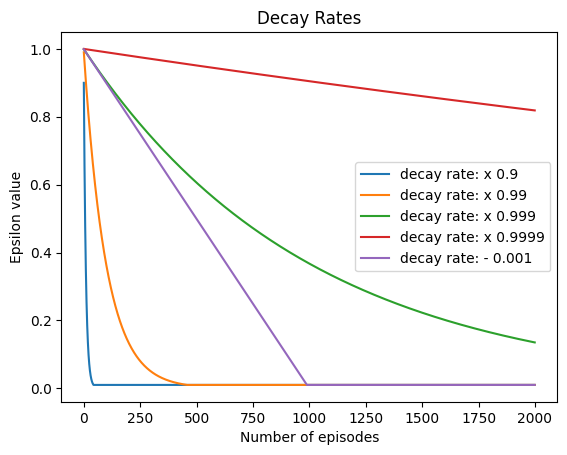

[(0.9, 1963), (0.99, 1876), (0.999, 1106), (0.9999, 179)]


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

decays =   [0.9, 0.99, 0.999, 0.9999]  
min_decay = 0.01
num_episodes = 2000

def greedy_action(epsilon):
        if np.random.random() < epsilon:
            return 0
        else: 
            return 1
        
#Multiplicative Decays
epsilon_decay = []
final_actions = []
for decay in decays:
    epsilon_episode = []
    epsilon = 1
    actions = []
    for i in range(num_episodes):
        epsilon = max(epsilon*decay,min_decay)
        actions.append(greedy_action(epsilon))
        epsilon_episode.append(epsilon)
    epsilon_decay.append(epsilon_episode)
    final_actions.append((decay,sum(actions)))
    
    
#Linear Decay
epsilon=1
actions = []
epsilon_episode = []
for i in range(num_episodes):
    epsilon = max(epsilon-0.001,min_decay)
    actions.append(greedy_action(epsilon))
    epsilon_episode.append(epsilon)

plt.plot(epsilon_decay[0],label = 'decay rate: x 0.9')
plt.plot(epsilon_decay[1],label = 'decay rate: x 0.99')
plt.plot(epsilon_decay[2],label = 'decay rate: x 0.999')
plt.plot(epsilon_decay[3],label = 'decay rate: x 0.9999')
plt.plot(epsilon_episode, label = 'decay rate: - 0.001')
plt.title('Decay Rates')
plt.legend(loc='best')
plt.xlabel('Number of episodes')
plt.ylabel('Epsilon value')
plt.show()

print(final_actions)


## Main

In [7]:
def update_epsilon():
        if epsilon < 0.01:
            return 0.01
        else:
            return epsilon * 0.999

In [8]:
class DQN:
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = seed
        
        # Initialize Q and Fixed Q networks
        self.online_Qnet = NeuralNetwork(self.state_size, self.action_size, self.seed).to(device)
        self.target_Qnet = NeuralNetwork(self.state_size, self.action_size, self.seed).to(device)
        self.optimizer = optim.Adam(self.online_Qnet.parameters())
        
        # Initiliase memory 
        self.memory = ReplayBuffer(256, seed)
       
        
    
    def add_memory(self, state, action, reward, next_state, done):
        self.memory.upload_memory(state, action, reward, next_state, done)
        
    def update(self, state, action, reward, next_state, done):
        if len(self.memory) > batch_size:
            samples = self.memory.sample_memory()
            states, actions, rewards, next_states, is_dones = samples
            max_actions = self.target_Qnet(next_states).detach().max(1)[0].unsqueeze(1)
            target = rewards+(max_actions*(1-is_dones)*gamma)
            expectation = self.online_Qnet(states).gather(1, actions)

            loss = F.mse_loss(expectation, target)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()


            parameters = zip(self.online_Qnet.parameters(), self.target_Qnet.parameters())
            for source, target in parameters:
                target.data.copy_(0.001 * source.data + (0.999) * target.data)


    def greedy_action(self, state, epsilon=0.0):
        if np.random.random() < epsilon:
            return np.random.randint(self.action_size)
        else: 
            actions = self.online_Qnet(torch.from_numpy(state).float().unsqueeze(0).to(device))
            
            return np.argmax(actions.cpu().data.numpy())
              

In [9]:
class ReplayBuffer:
    def __init__(self, batch_size, seed):
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        self.memory = []*100000
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
      
    def sample_memory(self):
        sequences =  random.sample(self.memory,self.batch_size)
        states = torch.from_numpy(self.stack_torch(sequences,"state")).float().to(device)
        actions = torch.from_numpy(self.stack_torch(sequences,"action")).long().to(device) 
        rewards = torch.from_numpy(self.stack_torch(sequences,"next_reward")).float().to(device)       
        next_states = torch.from_numpy(self.stack_torch(sequences,"next_state")).float().to(device)
        is_dones = torch.from_numpy(self.stack_torch(sequences,"is_done").astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, is_dones)
    
    def upload_memory(self, state, action, reward, next_state, done):
        self.memory.append(self.experience(state, action, reward, next_state, done))
        
    def stack_torch(self,sequences,observation):
        observations = ['state','action','next_reward','next_state','is_done']
        index = observations.index(observation)
        observation_list = []
        for sequence in sequences:
            observation_list.append(sequence[index])
            
        return np.vstack(observation_list)
    
    def storage(self):
        if not self.memory:
            print("Empty Memory")
        else:
            print("Memory:", len(self.memory))

    def reset_memory(self):
        self.memory = []  
        
    def __len__(self):
        
        return len(self.memory)

In [10]:

        
start = time()
env = gym.make('LunarLander-v2')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQN(state_size, action_size, seed=0)
scores_list = []

batch_size = 256         
gamma = 0.99  
n_episodes = 1000
epsilon = 1 
update_step = 0
max_length = 1000

scores_window = deque(maxlen=100)
for episode in range(n_episodes):
    state = env.reset()
    score = 0
    for i in range(max_length):
        update_step +=1 
        action = agent.greedy_action(state,epsilon)
        next_state, reward, is_done,_ = env.step(action)
        
        agent.add_memory(state, action, reward, next_state, is_done)
        
        if update_step % 4 == 0:
            agent.update(state, action, reward, next_state, is_done)
        
        state = next_state        
        score += reward        
        if is_done:
            break
            
#------------------------------------------------------------------------------------------------------------------------------
        if episode % 1 == 0:
            mean_score = np.mean(scores_window)
            print('\r Progress {}/{}, average score:{:.2f}'.format(episode, n_episodes, mean_score), end="")
        
#------------------------------------------------------------------------------------------------------------------------------
       
        epsilon = update_epsilon() 
    scores_list.append(score)
    scores_window.append(score)
end = time()

C:\Users\Jan Ramos\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Jan Ramos\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 Progress 999/1000, average score:172.683

Text(0, 0.5, 'Game Score')

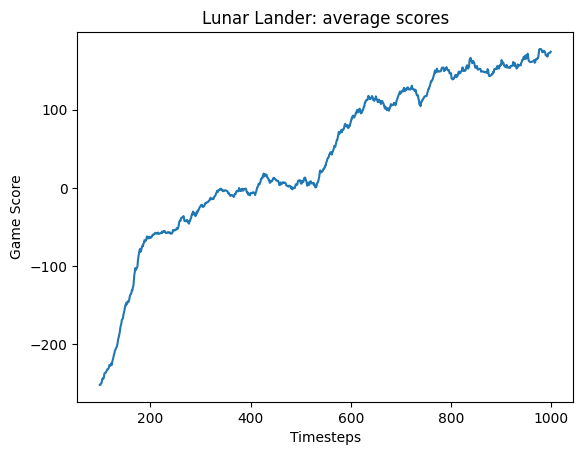

In [13]:
plt.plot(pd.Series(scores_list).rolling(100).mean())
plt.title("Lunar Lander: average scores")
plt.xlabel("Timesteps")
plt.ylabel("Game Score")